# 📌 Next-Generation Spam Filter — OEC-Net 
- 使用 TF-IDF + PCA
- PSO 特徵選擇（含交叉驗證）
- CNN 結構同期刊設計
- 中文繁體 `test.csv` 多類分類任務

In [25]:
import pandas as pd
import re
import jieba
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("test.csv")
df['text'] = df['subject'].fillna('') + ' ' + df['message'].fillna('')

stop_words = set(stopwords.words('english'))  # 可自定義中文停用詞集

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', ' ', text)# 保留中英文與數字
    words = jieba.lcut(text)
    return ' '.join([w for w in words if w not in stop_words and len(w) > 1])

df['clean_text'] = df['text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,subject,message,label,text,clean_text
0,The FuelCell Rebel,全新顏色\n\nNew Balance\nhttps://link.email.newbal...,5,The FuelCell Rebel 全新顏色\n\nNew Balance\nhttps:...,The FuelCell Rebel 全新 顏色 New Balance 男裝 女裝 兒童 ...
1,1111人力銀行推薦 -【桃園台茂店【涮乃葉】兼職人員及大專院校實習】,\n \n 轉寄履歷-簡式版\n\n \n \n ...,3,1111人力銀行推薦 -【桃園台茂店【涮乃葉】兼職人員及大專院校實習】 \n \n ...,1111 人力 銀行 推薦 桃園 台茂店 乃葉 兼職 人員及 大專 院校 實習 轉寄履歷 簡...
2,陳任璿-2025/03/16 履歷職缺配對通知,\n 職缺配對 \n ...,3,陳任璿-2025/03/16 履歷職缺配對通知 \n 職缺配對 ...,2025 03 16 履歷職 缺配 通知 職缺配 寄送 期待 配對 職缺 這些 職位 符合 ...
3,你的 Apple 開立發票通知,\n \n開立發票通知\n\n\n APPLE 帳號dana43261...,2,你的 Apple 開立發票通知 \n \n開立發票通知\n\n\n A...,Apple 開立 發票 通知 開立 發票 通知 APPLE 帳號 dana4326172 g...
4,大谷翔平，準備好續集,The Ohtani Signature Collection\n\nNew Balance...,5,大谷翔平，準備好續集 The Ohtani Signature Collection\n\n...,大谷 翔平 準備 好續 The Ohtani Signature Collection Ne...


In [26]:
# 對每封信件進行斷詞、去除網址與停用詞，並建立清洗後的新欄位
from sklearn.model_selection import train_test_split
from collections import Counter

# 切分資料（80% 訓練，20% 驗證），並保留 label 分布比例
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

# 顯示各類別數量
def print_label_counts(title, y):
    counter = Counter(y)
    print(f"{title}：")
    for label in sorted(counter):
        print(f"類別 {label}：{counter[label]} 筆")

print_label_counts("訓練集 各類別數量", y_train)
print()
print_label_counts("驗證集 各類別數量", y_test)


訓練集 各類別數量：
類別 0：240 筆
類別 1：44 筆
類別 2：338 筆
類別 3：469 筆
類別 4：361 筆
類別 5：243 筆
類別 6：145 筆

驗證集 各類別數量：
類別 0：60 筆
類別 1：11 筆
類別 2：84 筆
類別 3：117 筆
類別 4：91 筆
類別 5：61 筆
類別 6：36 筆


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 使用 TfidfVectorizer 將文字轉為 5000 維向量
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# 降維到 100 維（PCA 主成分分析
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf)
X_test_pca = pca.transform(X_test_tfidf)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# 定義 sigmoid 函式
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 定義模型評估函式：使用邏輯迴歸進行交叉驗證
def evaluate(X_sub, y):
    clf = LogisticRegression(max_iter=500)
    scores = cross_val_score(clf, X_sub, y, cv=3, scoring='accuracy')
    return np.mean(scores)

# 粒子群最佳化演算法：挑選表現最好的特徵組合
def pso_feature_selection(X, y, num_particles=20, max_iter=10):
    n_features = X.shape[1]
    particles = np.random.randint(0, 2, (num_particles, n_features))
    velocities = np.random.uniform(-1, 1, (num_particles, n_features))
    p_best = particles.copy()
    p_best_scores = np.array([evaluate(X[:, p == 1], y) for p in particles])
    g_best = p_best[np.argmax(p_best_scores)]

    for _ in range(max_iter):
        for i in range(num_particles):
            r1, r2 = np.random.rand(n_features), np.random.rand(n_features)
            velocities[i] = 0.7 * velocities[i] + 1.5 * r1 * (p_best[i] - particles[i]) + 1.5 * r2 * (g_best - particles[i])
            particles[i] = np.where(np.random.rand(n_features) < sigmoid(velocities[i]), 1, 0)
            if np.sum(particles[i]) == 0:
                particles[i, np.random.randint(0, n_features)] = 1
            score = evaluate(X[:, particles[i] == 1], y)
            if score > p_best_scores[i]:
                p_best[i] = particles[i]
                p_best_scores[i] = score
        g_best = p_best[np.argmax(p_best_scores)]
    return np.where(g_best == 1)[0]

selected_idx = pso_feature_selection(X_train_pca, y_train)
X_train_sel = X_train_pca[:, selected_idx]
X_test_sel = X_test_pca[:, selected_idx]
print("✅ 選出特徵數量：", len(selected_idx))


✅ 選出特徵數量： 63


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

model = keras.Sequential([
    layers.Input(shape=(X_train_sel.shape[1], 1)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train_final = np.expand_dims(X_train_sel, axis=-1)
X_test_final = np.expand_dims(X_test_sel, axis=-1)

history = model.fit(
    X_train_final, y_train,
    validation_data=(X_test_final, y_test),
    epochs=15,
    batch_size=32
)


Epoch 1/15
58/58 [==============================] - 1s 8ms/step - loss: 1.7564 - accuracy: 0.2946 - val_loss: 1.5478 - val_accuracy: 0.4022
Epoch 2/15
58/58 [==============================] - 0s 5ms/step - loss: 1.2643 - accuracy: 0.5424 - val_loss: 0.9983 - val_accuracy: 0.6717
Epoch 3/15
58/58 [==============================] - 0s 5ms/step - loss: 0.8791 - accuracy: 0.7245 - val_loss: 0.7871 - val_accuracy: 0.7326
Epoch 4/15
58/58 [==============================] - 0s 5ms/step - loss: 0.7395 - accuracy: 0.7522 - val_loss: 0.6774 - val_accuracy: 0.7652
Epoch 5/15
58/58 [==============================] - 0s 5ms/step - loss: 0.6488 - accuracy: 0.7848 - val_loss: 0.6304 - val_accuracy: 0.7848
Epoch 6/15
58/58 [==============================] - 0s 5ms/step - loss: 0.6003 - accuracy: 0.8005 - val_loss: 0.6006 - val_accuracy: 0.7891
Epoch 7/15
58/58 [==============================] - 0s 5ms/step - loss: 0.5569 - accuracy: 0.8174 - val_loss: 0.5424 - val_accuracy: 0.8109
Epoch 8/15
58/58 [==

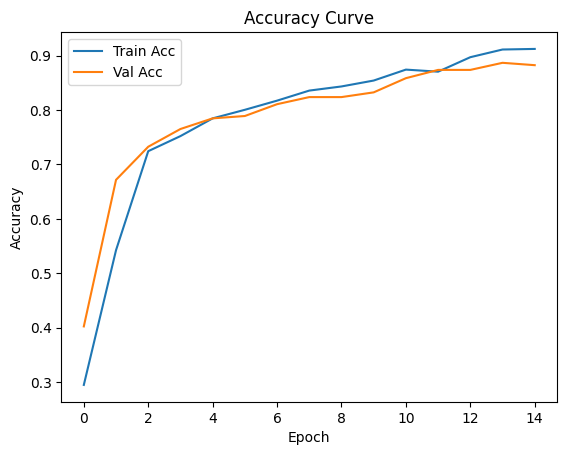

15/15 [==============================] - 0s 957us/step


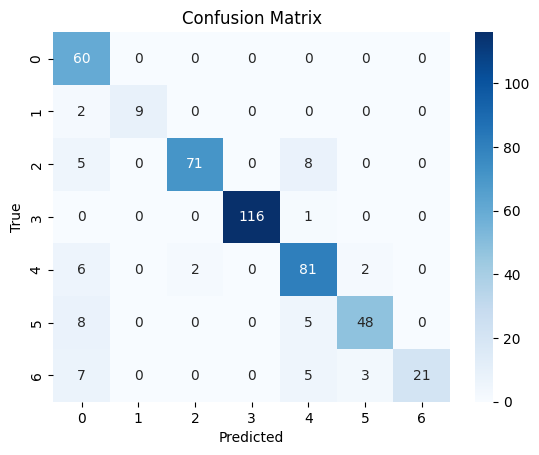

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        60
           1       1.00      0.82      0.90        11
           2       0.97      0.85      0.90        84
           3       1.00      0.99      1.00       117
           4       0.81      0.89      0.85        91
           5       0.91      0.79      0.84        61
           6       1.00      0.58      0.74        36

    accuracy                           0.88       460
   macro avg       0.91      0.85      0.86       460
weighted avg       0.90      0.88      0.88       460



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

y_pred = model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_labels))
